In [1]:
import random

%matplotlib inline
import networkx as nx


# 第 6 章

目次：

1. 分割
2. モジュラリティ
3. ザカリー空手クラブ
4. Girvan-Newman クラスタリング・アルゴリズム



## 1. 分割

グラフの**分割**とは、そのノードを互いに重なっていないなグループに分離することである。次のグラフを検討させたい。


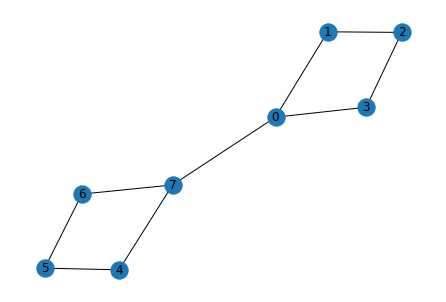

In [2]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)


以下は、これらのノードの分割の一例である。


In [3]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]


グラフ内のすべてのノードが、分割内のセットの 1 つだけにあることに注意させたい。形式的には、分割は、すべてのノードがちょうど 1 つのセットに含まれるようなセットのリストである。 NetworkX は、分割の有効性を確かめることができる。


In [4]:
nx.community.is_partition(G, partition)

True


コミュニティ検出アルゴリズムを開発するとき、*分割マップ*をよく利用する。これは、ノード名から分割のインデックスにマッピングする辞書である。これは、2 つのノードがある分割での同じクラスターにあるかどうかをすばやく比較するのに役立つことができる。


In [5]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}


この辞書では、キーはノード名であり、2 つのノードが同じ分割にある場合、それらの値は同じになるはずである。


In [6]:
partition_map[0] == partition_map[7]

True


分割のクラスターによって色分けされたノードを使用してグラフを描画することで、分割ることができる。


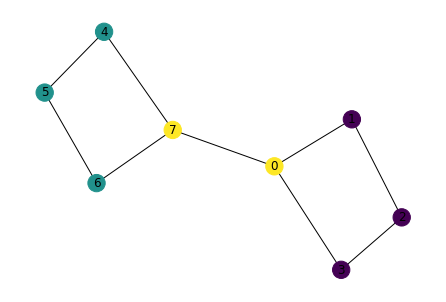

In [7]:
node_colors = [partition_map[n] for n in G.nodes]
        
nx.draw(G, node_color=node_colors, with_labels=True)


2 つの素朴な分割：

1. すべてのノードを含む 1 つのセットしか持たない分割
2. それぞれが 1 つのノードを含む N 個のセットを持つ分割

がある。したがって、有効な分割には 1 ～ N 個のセットがある。

前述した分割を変更し、後続のセルを実行して自由に実験せよ。



## 2. モジュラリティ

大まかに言うと、ネットワークのコミュニティのサブタスクの一つは、ノードのグループ間を適切に分離する分割を見つけることで構成される。グラフの適切な分割を見つける方法に入る前に、評価方法、つまり、分割がどの程度良好かを測定する方法が必要である。モジュラリティは、そのような目的関数の 1 つである。

グラフ分割のモジュラリティは、クラスタ内エッジの数をランダムなベースラインと比較する。モジュラリティスコアが高いことは、グループ内エッジの割合が高くなるため、グループ間エッジが少なくなり、グループの分離が向上することを意味する。

テキストで説明されているように、重み付けされた無向ネットワークの場合、

\begin{equation}
    Q_w=\frac{1}{W}\sum_C \left(W_C-\frac{s_C^2}{4W}\right),
\end{equation}

が成り立つ。ただし、
- $W$ はネットワークのリンクの総重み
- $W_C$ はクラスタ $C$ の内部リンクの総重み
- $s_C$ は $C$ のノードの合計強度

である。エッジの数 $L$ が総次数の半分であるのと同じ理由で、総重み $W$ は総強度の半分である。この式は少し複雑に見えるかもしれませんが、下に示したように、合計を計算するコードを書くのは簡単である。


In [8]:
def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # Use subgraph to count only internal links
        C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)
    
    return summation / W

In [9]:
modularity(G, partition)

0.2222222222222222


これを、モジュラリティが高いと思われる分割と比べたい。


In [10]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
modularity(G, partition_2)

0.3888888888888889


### NetworkX の関数

NetworkX は、前に述べたものよりも効率的なモジュラリティ関数を提供する。


In [11]:
nx.community.quality.modularity(G, partition_2)

0.38888888888888884


## 3. ザカリー空手クラブ



コミュニティ検出アルゴリズムを作成およびテストする場合、ベンチマークとなるネットワーク (既知の「自然な」コミュニティ構造を持つグラフ) を利用すると役立つ。おそらく最も有名なベンチマークグラフは、ザカリー空手クラブ（Zachary's Karate Club）だろう。これには、空手クラブのメンバーを表す 34 個のノードが含まれており、メンバーたちのインタラクションは研究者によって 3 年間にわたって監視されている。このグラフのリンクは、クラブ活動以外で交流する個人の結びつきなど、社会的つながりを代表する。

調査の過程で、講師の Hi 氏 (ノード 0) と会長 (ノード 33) との間の対立により、クラブは Hi 氏と会長が率いる別々のグループに分割されました。この場合、グループの各メンバーが分割後に誰をフォローしたかがわかるため、経験的なコミュニティ・ラベルが提供される。Hi 氏をフォローしたメンバーは一方のコミュニティであり、会長をフォローしたメンバーは他方のコミュニティである。

このグラフでは、分割後のグループ構成は主に社会的つながりによって左右されたと想定される。つまり、同じ友人グループのメンバーは、分割後に同じクラブの一員になりたいと思われる。したがって、分割後のグループ構成を高精度で予測するための優れたコミュニティ検出アルゴリズムが期待される。

ザカリー空手クラブは非常に人気のあるベンチマーク・グラフであり、NetworkX で独自の機能を備えている。


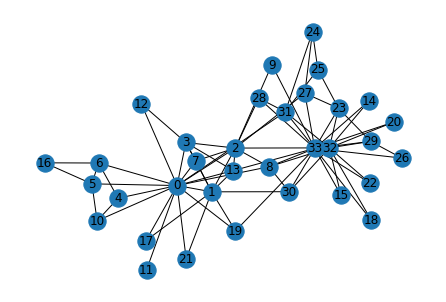

In [12]:
K = nx.karate_club_graph()
nx.draw(K, with_labels=True)


グラフの各ノードには、関連付けられた*属性*の辞書オブジェクトがあり、この辞書にはノードに関する任意のデータが保持される。`nodes` オブジェクトにノード名を指定することで、単一ノードの属性を取得できる。

このグラフの各ノードには `'club'` 属性があり、分割後にメンバーがインストラクターまたは社長のどちらをフォローしたかを示している。


In [13]:
K.nodes[0]

{'club': 'Mr. Hi'}

In [14]:
K.nodes[9]

{'club': 'Officer'}


`'club'` 属性で各ノードに色分けることで、これらのラベルを視覚化できる。


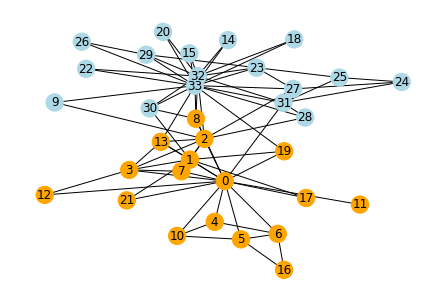

In [15]:
K = nx.karate_club_graph()
club_color = {
    'Mr. Hi': 'orange',
    'Officer': 'lightblue',
}
node_colors = [club_color[K.nodes[n]['club']] for n in K.nodes]
nx.draw(K, node_color=node_colors, with_labels=True)


コミュニティ内のリンクとは対照的に、コミュニティ間のリンクが比較的少ないという点で、この分離はいいように見える。これらのラベルに基づいてグラフを分割し、そのモジュラリティを測定したい。

これを行うには、まず、ノードの `'club'` 属性の値ごとに 1 つずつ、2 つのセットの辞書を作成し、ノードを対応するセットに割り当てる。


In [16]:
groups = {
    'Mr. Hi': set(),
    'Officer': set(),
}

for n in K.nodes:
    club = K.nodes[n]['club']
    groups[club].add(n)
    
groups

{'Mr. Hi': {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 'Officer': {9,
  14,
  15,
  18,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}}


辞書の`.values()`メソッドを使用して、分割内のそれぞれのセットのリストを取得できる。


In [17]:
empirical_partition = list(groups.values())
empirical_partition

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

In [18]:
nx.community.is_partition(K, empirical_partition)

True

この分割は確かに有効なので、そのモジュラリティを得ることができる。

In [19]:
nx.community.quality.modularity(K, empirical_partition)

0.39143756676224206


期待通りに、これは比較的高いモジュラリティである。

### ランダム分割との比較

比較のために、このネットワークのランダム分割とそのモジュラリティを確認したい。この場合、モジュラリティはゼロに近いと予想される。

まず、全ノード数の半分である 17 ノードのサンプルを生成し、それらを 1 つのコミュニティに割り当てる。次に、2 番目のコミュニティには、最初のコミュニティに含まれない全てのノードが含まれる。これを簡潔に行うために集合演算を使用したい。


In [20]:
random_nodes = random.sample(K.nodes, 17)
random_partition = [set(random_nodes),
                    set(K.nodes) - set(random_nodes)]
random_partition

since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(K.nodes, 17)


[{0, 1, 2, 3, 6, 8, 11, 12, 16, 17, 22, 23, 25, 26, 28, 32, 33},
 {4, 5, 7, 9, 10, 13, 14, 15, 18, 19, 20, 21, 24, 27, 29, 30, 31}]


この分割を可視化すると、ランダムな割り当てから予想されるように、コミュニティがあまり自然に見えないことがわかる。


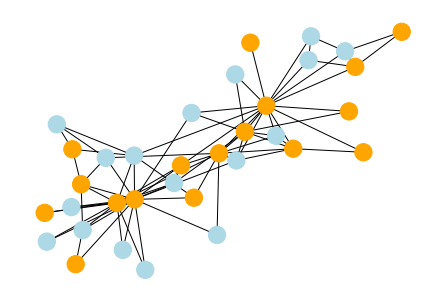

In [21]:
random_node_colors = ['orange' if n in random_nodes else 'lightblue' for n in K.nodes]
nx.draw(K, node_color=random_node_colors)


最後に、この分割のモジュラリティをテストする。


In [22]:
nx.community.quality.modularity(K, random_partition)

-0.1327936133130938


これはランダムなプロセスであるため、モジュラリティが完全にゼロになることはないが、かなり近いはずである。ランダム分割とそのモジュラリティをテストするプロセスを繰り返せば、その平均値ゼロを中心に変動すると分かる。



# 4. Girvan-Newman クラスタリング

このパートのには、Girvan-Newman クラスタリングアルゴリズムが実装される。 NetworkX は私たちに代わって重労働 (媒介中心性の計算) を行うことができるので、タスクのコード部分は比較的簡単である。ここでの私たちの努力のほとんどは、中間結果の解釈と説明に費やされる。

テキストから Girvan-Newman クラスタリングアルゴリズムを思い出せたい。

1. 分割のシーケンスを作成する
2. すべてのリンクの媒介中心性を計算する
3. 媒介中心性が最大のリンクを削除し、連結成分を使用して分割を作る
4. 結果のグラフのリンクの媒介中心性を再計算する
5. リンクがなくなるまで、3 番目から繰り返す
6. シーケンス内の各分割モジュラリティが最も高いものを選ぶ

このプロセスの間、クラスターが分割されるにつれて、グラフ内の連結成分の数は単調に増加する。一度に 1 つのリンクを削除するため、連結成分の数は、シーケンスのステップ間で最大 1 を増加する。それは、1 エッジが 2 以上のノード、すなわちコンポーネントを接続することはできないためである。

この分割の結果がグラフの背後のコミュニティ構造に近似することを願う。ここでは空手クラブのグラフを使用して検証する。これは、グラウンド・トゥルースのコミュニティラベルを知っており、アルゴリズムから得られた結果を比較できるためである。


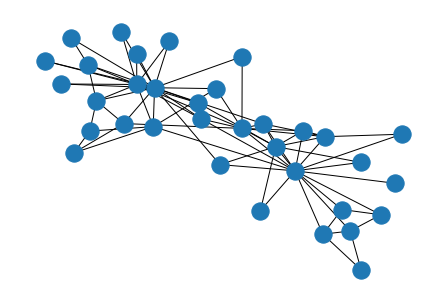

In [23]:
G = nx.karate_club_graph()
nx.draw(G)


## 4.1 分割シーケンスの作成

### イ　すべてのリンクの媒介中心性を計算する

NetworkX はここで面倒な作業を行うので、私たちがしなければならないことは、出力を理解することだけ。


In [24]:
nx.edge_betweenness_centrality(G)

{(0, 1): 0.025252525252525245,
 (0, 2): 0.0777876807288572,
 (0, 3): 0.02049910873440285,
 (0, 4): 0.0522875816993464,
 (0, 5): 0.07813428401663694,
 (0, 6): 0.07813428401663695,
 (0, 7): 0.0228206434088787,
 (0, 8): 0.07423959482783014,
 (0, 10): 0.0522875816993464,
 (0, 11): 0.058823529411764705,
 (0, 12): 0.04652406417112298,
 (0, 13): 0.04237189825425121,
 (0, 17): 0.04012392835922248,
 (0, 19): 0.045936960642843,
 (0, 21): 0.040123928359222474,
 (0, 31): 0.1272599949070537,
 (1, 2): 0.023232323232323233,
 (1, 3): 0.0077243018419489,
 (1, 7): 0.007422969187675069,
 (1, 13): 0.01240556828792123,
 (1, 17): 0.01869960105254222,
 (1, 19): 0.014633732280791102,
 (1, 21): 0.01869960105254222,
 (1, 30): 0.032280791104320514,
 (2, 3): 0.022430184194890075,
 (2, 7): 0.025214328155504617,
 (2, 8): 0.009175791528732704,
 (2, 9): 0.030803836686189627,
 (2, 13): 0.007630931160342923,
 (2, 27): 0.04119203236850296,
 (2, 28): 0.02278244631185807,
 (2, 32): 0.06898678663384543,
 (3, 7): 0.00336558


結果はエッジがキーであり、そのエッジの中間中心性が値となる辞書オブジェクトである。グラフ内のすべてのエッジの中心性を計算するアルゴリズムは、単一のエッジに対して計算するのとほぼ同じコストがかかるため、すべてのエッジの計算値を利用したい。

すべてのエッジについて中心性を計算すると、単一のエッジに関連付けられた中心性を簡単に取得できる。たとえば、ノード 0 と 1 の間のエッジの中間性を取得するには、次のようにする。


In [25]:
my_edge_betweenness = nx.edge_betweenness_centrality(G)
my_edge_betweenness[0, 1]

0.025252525252525245


辞書にも `.get` メソッドがあることを思い出せたい。これは次のステップで使用される。


In [26]:
my_edge_betweenness.get((0, 1))

0.025252525252525245


### ロ　媒介中心性が最大のリンクを削除する

各エッジの中間値の辞書が与えられると、Python の組み込みの `max` 関数を使用して、この辞書内の最大値を持つキーを得ることができる。グラフのすべてのエッジのに対して辞書にはキーがあるため、次の 2 つの式は同等が、わかりやすさの視点から、おそらく 2 番目の式の方がより明確である。

`my_edge_betweenness` という名前を使用して、これが NetworkX の関数ではなく、名前を付けた辞書であることを明確にしたい。


In [27]:
max(my_edge_betweenness, key=my_edge_betweenness.get)

(0, 31)

In [28]:
max(G.edges(), key=my_edge_betweenness.get)

(0, 31)


上記のエッジがこのステップで削除すべきエッジである。


In [29]:
my_edge_betweenness = nx.edge_betweenness_centrality(G)
most_valuable_edge = max(G.edges(), key=my_edge_betweenness.get)
G.remove_edge(*most_valuable_edge)

上のセルの最後のステートメントの「スプラット」演算子 `G.remove_edge(*most_valuable_edge)` は、タプルを解列し、その中身を順番から関数の引数として定めるものである。例えば、`most_valuable_edge` が `(0, 31)` であると、

    G.remove_edge(*most_valuable_edge)
は
    
    G.remove_edge(most_valuable_edge[0], most_valuable_edge[1])
または

    G.remove_edge(0, 31)

と等価する。


### ロ（続き）　……そして、連結成分を使用して分割を作る

`nx.connected_components()` 関数はほぼ正確に必要なものを提供するため、これはとても簡単だった。


In [30]:
nx.connected_components(G)

<generator object connected_components at 0x000002D90DB60270>


リストで結果を保存することをお忘れなく。


In [31]:
list(nx.connected_components(G))

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}]

覚えておこう：分割には、グラフのノードがちょうど 1 つのその中のセットに含まれるのである。エッジを 1 つしか削除していないので、連結成分はまだ1つである。もしお望みなら、1つ以上の連結成分ができるまで、前の2つのセルを数回実行しなければならない。

連結成分が推定されたコミュニティのラベルに正確に対応するというこの特徴は、Girvan-Newman アルゴリズム特有のものであることに注意してほしい。


### ハ　結果のグラフのリンクの媒介中心性を再計算する

### ニ　リンクがなくなるまで、ロから繰り返す

これは、このプロセスをエッジごとに $L$ 回繰り返すループ必要があり、生成された分割を記録する必要があることを意味する。簡単なもの。上記のいくつかのエッジを削除したので、新しく作った空手クラブのグラフから始めたい。


In [32]:
G = nx.karate_club_graph()
partition_sequence = []
for _ in range(G.number_of_edges()):
    my_edge_betweenness = nx.edge_betweenness_centrality(G)
    most_valuable_edge = max(G.edges(), key=my_edge_betweenness.get)
    G.remove_edge(*most_valuable_edge)
    my_partition = list(nx.connected_components(G))
    partition_sequence.append(my_partition)

この `for` ループのイディオム的な構造に注目してほしい。ループ変数の名前に `_` を使うことで、ループ変数で何かすることを期待しているわけではなく、あるタスクを特定の回数だけ実行したいだけであることを読者に伝えることができる。ここで `while` ループを使いたくなるかもしれないが、その方法はドラゴンが潜んでいる：`while` ループでミスをすると、頭痛の種である無限ループにつながる可能性がある。

もしこれが正しくできていれば、最後得られた分割の数は、プロセスの各ステップ、つまりグラフの各辺と等しくなるはず。

In [33]:
len(partition_sequence), nx.karate_club_graph().number_of_edges()

(78, 78)


連結グラフから始めたので、エッジを 1 つ削除してもおそらくグラフは切断されないため、最初の分割にはおそらく 1 つのコミュニティしかない。


In [34]:
len(partition_sequence[0])

1


そして、最後の分割は、それぞれのノードが独自のコミュニティ内にある素朴なものとなるはず。


In [35]:
len(partition_sequence[-1]), nx.karate_club_graph().number_of_nodes()

(34, 34)


## 4.2 シーケンス内の各分割のモジュラリティを評価する

これで分割のシーケンスと、各々の分割のモジュラリティを計算する関数ができた。リスト内包を使う絶好の機会です！


In [36]:
G = nx.karate_club_graph()
modularity_sequence = [modularity(G, p) for p in partition_sequence]
modularity_sequence

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.34766027623170476,
 0.34766027623170476,
 0.34766027623170476,
 0.3423192968647515,
 0.3423192968647515,
 0.3423192968647515,
 0.3423192968647515,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.38497217068645645,
 0.37578006409175246,
 0.37578006409175246,
 0.3594760218136842,
 0.3594760218136842,
 0.3470699574595679,
 0.3470699574595679,
 0.333249002080171,
 0.333249002080171,
 0.3134405277262421,
 0.3134405277262421,
 0.3122598901819681,
 0.3122598901819681,
 0.3036862127771219,
 0.3036862127771219,
 0.2942973332583722,
 0.2942973332583722,
 0.2827158411573995,
 0.2827158411573995,
 0.27116245947414774,
 0.27116245947414774,
 0.2544648713479881,
 0.2544648713479881,
 0.2397537527407657,
 0.2397537527407657,
 0.22689792170311643,
 0.22299057363992422,
 0.22299057363992422,
 0.22299057363992422,
 0.20056783043796034,
 0.20056783043796034,
 0.1


このシーケンスには、アルゴリズムの各ステップでの分割のモジュラリティルがある。このシーケンスの最初のいくつかの要素は、コミュニティ（あるいは連結成分）が 1 つしかない間は事実上ゼロであり、複数のコミュニティが存在すると飛躍的に上がるのである。 pyplot を使用して、この関係を視覚化したい。


Text(0.5, 0, 'Algorithm step')

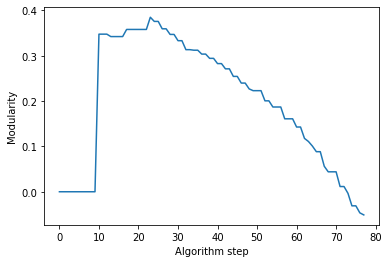

In [37]:
import matplotlib.pyplot as plt
plt.plot(modularity_sequence)
plt.ylabel('Modularity')
plt.xlabel('Algorithm step')


### モジュラリティが最も高い分割を得る



視覚的には、モジュラリティシーケンスにピークが見られ、その値はモジュラリティを最大化する分割であり、アルゴリズムの出力でもある。 `max` 関数を使用して、モジュラリティが最も高い分割を取得できる。直感的には、次のように記述したい。


In [38]:
best_partition = max(partition_sequence, key=nx.community.quality.modularity)

TypeError: modularity() missing 1 required positional argument: 'communities'

...but we receive an error. Recall that a key function must take exactly one argument, the item in the sequence being evaluated, but the modularity function takes two arguments: the graph and the partition. We can fix this by writing a single-argument function to use as the key:

……しかし、エラーが発生する。キー関数は正確に 1 つの引数（評価されるシーケンスのアイテム）をとらなければならないが、モジュラリティ関数は 2 つの引数（グラフとその分割）をとることを思い出してほしい。これを解決するには、キーとして使う引数 1 つの関数を作ればいい。

In [39]:
def my_modularity(partition):
    return nx.community.quality.modularity(G, partition)
best_partition = max(partition_sequence, key=my_modularity)

上級の Python プログラマーなら、`zip` 関数を使って以前に生成された分割とモジュラリティの並びを整列させるという別の解決策を見ることができるだろうが、この解決策はより明示的である。

それでは、すべての作業の後、最良の分割は？

In [40]:
best_partition

[{0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
 {2, 24, 25, 27, 28, 31},
 {4, 5, 6, 10, 16},
 {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
 {9}]


面白い！モジュラリティが最も高い空手クラブの分割には 5 つのコンポーネントがある！このチュートリアルの冒頭で書き戻した分割マップを作るコード用して、それらを可視化したい。


In [41]:
def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

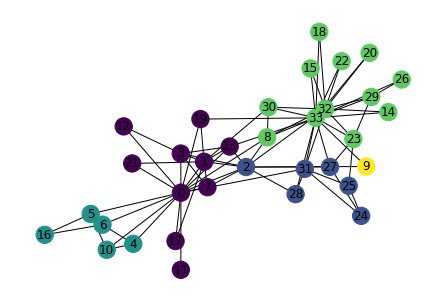

In [42]:
best_partition_map = create_partition_map(best_partition)

node_colors = [best_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)


この 5 つのコミュニティの分割は、いったいどの程度優れているのだろうか？


In [43]:
nx.community.quality.modularity(G, best_partition)

0.3849721706864564

第 3 節で評価した、グラウンド・トゥルーズの分割よりも高く、これは良い兆候であろうが、分割後のコミュニティ・メンバーシップを予測しようとする特定の問題に対しては、5 つのグループにクラスタリングすることは役に立たない。

### コミュニティ数を指定しで最良の分割を得る

Girvan-Newman アルゴリズムの最も有用な部分の1つは、欲しいクラスタ数が決まれることである。この場合、空手部は 2 つのグループに分かれることが分かっているので、2 つの連結成分を持つシーケンスで分割を得よう。

In [44]:
for partition in partition_sequence:
    if len(partition) == 2:
        two_cluster_partition = partition
        break

two_cluster_partition

[{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

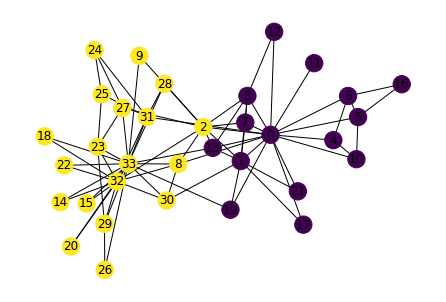

In [45]:
two_cluster_partition_map = create_partition_map(two_cluster_partition)

node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)


この分割い良いですか？そのモジュラリティを得ることができるので検証したい。


In [46]:
nx.community.quality.modularity(G, two_cluster_partition)

0.3476602762317048


かなり良い。グラウンド・トゥルースの分割に匹敵するんだ。これらを並べて比較したい。


Text(0.5, 1.0, 'Actual communities')

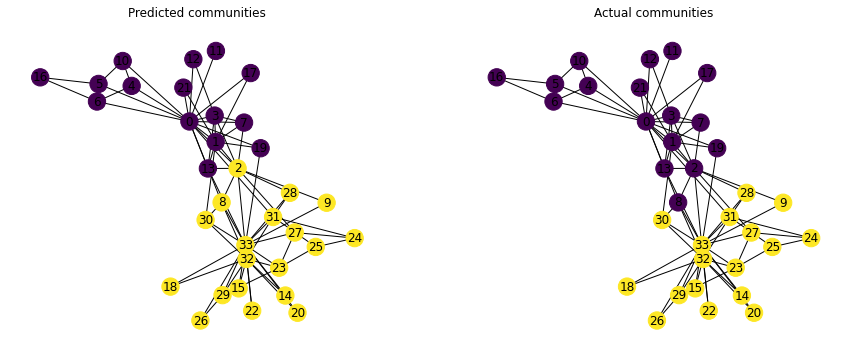

In [47]:
import matplotlib.pyplot as plt

pos = nx.layout.spring_layout(G)
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
two_cluster_partition_map = create_partition_map(two_cluster_partition)
node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Predicted communities')

plt.subplot(1, 2, 2)
node_colors = [G.nodes[n]['club'] == 'Officer' for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Actual communities')

ザカリーの元の論文では、このような予測ミスのノードの 1 つについて、実用的な考察まで説明している。この予測ミスは、生徒 8 は Hi 先生から黒帯を受け取る寸前であったため、何人かの友人が離れたにもかかわらず、グループを離れたくなかったためである。

In [48]:
G.nodes[8]

{'club': 'Mr. Hi'}

#### 余談

勘のいい読者なら、我々が生成した分割の列の中に 2 クラスタ分割がいくつかあるかもしれないことに気づくかもしれない。我々は以下のことが真実であると断言する：

1. 1.ノード数 1 から N の整数ごとに、その数のクラスタを持つパーティションが存在する
2. シーケンスにある同じクラスタ数の分割はすべて等しいである

これらを証明することは読者への練習として残されるが、これらが真であることの結果として、Girvan-Newman アルゴリズムの最適化された実装は、各クラスタ数に対して 1 つのパーティションしか保存しない。NetworkXの 実装はこのように動作し、1以上のコミュニティ数に対して1つのパーティションしか与えない。


## NetworkX の関数

`nx.community.girvan_newman(G)` はサイズが 1 より大きい分割を一つずつ生成する。ここで、最初のいくつかが私たちが生成したものと同じであることがわかる。


In [49]:
list(nx.community.girvan_newman(G))[:5]

[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}),
 ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {9}),
 ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {4, 5, 6, 10, 16},
  {9}),
 ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
  {2, 24, 25, 27, 28, 31},
  {4, 5, 6, 10, 16},
  {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
  {9}),
 ({0, 1, 3, 7, 12, 13, 17, 19, 21},
  {2, 24, 25, 27, 28, 31},
  {4, 5, 6, 10, 16},
  {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
  {9},
  {11})]